## Курс «Библиотеки Python для Data Science: продолжение»

### Курсовой проект

#### Задача

На основании имеющихся данных о клиентах банка, построить модель, используя обучающий датасет, для прогнозирования невыполнения долговых обязательств по текущему кредиту. Выполнить прогноз для примеров из тестового датасета.

#### Целевая переменная

Credit Default - дефолт по кредиту (факт невыполнения кредитных обязательств)

#### Метрика качества

F1-score

#### Требования к решению

Целевая метрика F1 > 0.5

Метрика оценивается по качеству прогноза для главного класса (1 - просрочка по кредиту)

Решение должно содержать Файл CSV с прогнозами целевой переменной для тестового датасета.

#### Подключение библиотек и скриптов

In [1]:
# !pip install tabulate
# !pip install catboost

In [2]:
import pandas as pd
import numpy as np
import pickle
import random

from IPython.display import HTML, display, Markdown
from tabulate import tabulate

from scipy.stats import shapiro
from scipy.stats import probplot
from scipy.stats import ttest_ind, mannwhitneyu
from scipy.stats import chi2_contingency
from statsmodels.stats.weightstats import zconfint

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, learning_curve
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
import xgboost as xgb, lightgbm as lgbm, catboost as catb

import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter('ignore')
# warnings.filterwarnings('ignore')
# %config InlineBackend.figure_format = 'svg'

#### Функции

In [3]:
# Обучение регрессора.
def build_regressor(df, columns, filed):
    X = df[df[filed].notnull()][columns]
    y = df[df[filed].notnull()][filed]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [4]:
# Заполнение пустых значений.
def predict_regressor(df, model, columns, filed):
    X = df[df[filed].isnull()][columns]
    y = model.predict(X)
    return y

In [5]:
# Расчёт диапазона, за границами которого все значения будут считаться выбросами.
def emissions(data):
    q1 = data.quantile(0.25)
    q3 = data.quantile(0.75)
    iqr = q3 - q1
    return (q1 - 1.5 * iqr, q3 + 1.5 * iqr)

In [6]:
# Обучение регрессора.
def build_regressor_outlier(df, columns, filed):
    X = df[columns]
    y = df[filed]
    model = LinearRegression()
    model.fit(X, y)
    return model

In [7]:
# Заполнение пустых значений.
def predict_regressor_outlier(df, model, columns, filed):
    X = df[columns]
    y = model.predict(X)
    return y

In [8]:
# Обработка выброса для конкретного поля.
def clear_outlier(data, field, columns):
    r_1, r_2 = emissions(data[field])
    if r_1 - r_2 != 0:
        share = round(data[(r_1 > data[field]) | (data[field] > r_2)].size/data.size*100, 2)
        print(f'"{field}"\nОбщая доля выбросов в процентах {share}%\n')
        if share > 5:
            model = build_regressor_outlier(data[(r_1 < data[field]) & (data[field] < r_2)], columns, filed)
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = predict_regressor_outlier(data[(r_1 > data[field]) | (data[field] > r_2)], model, columns, filed)
        else:
            data.loc[(r_1 > data[field]) | (data[field] > r_2), field] = data[(r_1 < data[field]) & (data[field] < r_2)][field].mode()[0]

In [9]:
# Обработка выбросов для всех полей конкретной выборки
def clear_outlier_all(data, columns):
    clear_outlier(data, 'Annual Income', columns)
    clear_outlier(data, 'Tax Liens', columns)
    clear_outlier(data, 'Number of Open Accounts', columns)
    clear_outlier(data, 'Years of Credit History', columns)
    clear_outlier(data, 'Maximum Open Credit', columns)
    clear_outlier(data, 'Number of Credit Problems', columns)
    clear_outlier(data, 'Months since last delinquent', columns)
    clear_outlier(data, 'Bankruptcies', columns)
    clear_outlier(data, 'Current Loan Amount', columns)
    clear_outlier(data, 'Current Credit Balance', columns)
    clear_outlier(data, 'Monthly Debt', columns)
    clear_outlier(data, 'Credit Score', columns)

In [10]:
def grouped_by_target(data, field, target):
    plt.figure(figsize=(10, 8))
    sns.set(font_scale=1)
    sns.countplot(x=field, hue=target, data=data)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.legend(title='Target', loc='upper right')
    plt.show()

In [11]:
def grouped_by_target_kde(data, field, target, n=1000):
    limit_bal_with_target_s = data[[field, target]]
    limit_bal_s = limit_bal_with_target_s[field]
    limit_bal_target_0 = limit_bal_s[limit_bal_with_target_s[target] == 0]
    limit_bal_target_1 = limit_bal_s[limit_bal_with_target_s[target] == 1]
    plt.figure(figsize=(10, 10))
    sns.kdeplot(limit_bal_target_0, shade=True, label='0', color='g')
    sns.kdeplot(limit_bal_target_1, shade=True, label='1', color='r')
    plt.xlabel(field)
    plt.title(f'"{field}" сгруппированная по целевой переменной')
    plt.show()

In [12]:
def combine_into_category(df, field, target, var_1, var_2, id, significancy=0.05):
    sample = df.loc[df[field].isin([var_1, var_2]), [id, field, target]]
    table = sample.pivot_table(values=id, index=field, columns=target, aggfunc='count')
    chi2, p, dof, expected = chi2_contingency(table, correction=False)
    return p > significancy

In [13]:
# Определение значения показателей, которые можно собрать в одно значение
def combine_into_category_table(df, field, target, id):
    values = df[field].unique()
    values_len = len(values)
    head =[' ']
    head.extend(values)
    result = [head]
    for i in range(values_len):
        row = [values[i]]
        for j in range(values_len):
            row.append(combine_into_category(df, field, target, values[i], values[j], id))
        result.append(row)
    dataToTable(result)

In [14]:
# Вывод данных в таблицу
def dataToTable(data):
    if len(data) == 0 :  
        display(HTML('<b>Нет данных</b>'))
        return
    dt = ''
    for i in range(len(data)):
        row = data[i]
        dt = dt + '<tr>'
        for j in range(len(row)):
            if j == 0:
                dt = dt + '<td>' + str(row[j]) + '</td>'
            elif i == j:
                dt = dt + '<td bgcolor="#CCCCFF"> </td>'
            else:
                if str(row[j]) == 'True':
                    dt = dt + '<td bgcolor="#CCFFCC" style="text-align: center; vertical-align: middle;">' + str(row[j]) + '</td>'
                elif str(row[j]) == 'False':
                    dt = dt + '<td bgcolor="#FFCCCC" style="text-align: center; vertical-align: middle;">' + str(row[j]) + '</td>'
                else:
                    dt = dt + '<td>' + str(row[j]) + '</td>'
        dt = dt + '</tr>'
            
    display(HTML('<table>' + dt + '</table>'))

In [15]:
# Визуализация
def bar_and_qq(data, column_name):
    plt.figure(figsize=(20, 8))
    ax1 = plt.subplot(121)
    ax1.set_xlabel(column_name)
    ax1.set_ylabel('Количество')
    ax1.set_title(f'Распределение «{column_name}»')
    data.hist()
    plt.subplot(122)
    probplot(data, dist='norm', plot=plt)
    plt.show()

In [16]:
def shapiro_wilk(data, column_name, significance=0.05):
    t, pv = shapiro(data)
    if pv < significance:
        t, pv = shapiro(np.log(data))
        if pv < significance:
            print(f'Показатель «{column_name}» не соответствует нормальному распределнию.')
        else:
            print(f'Показатель «{column_name}» показатель нормализуется операцией логарифмирования.')
    else:
        print(f'Показатель «{column_name}» показатель нормально нормализован.')
    print('Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.')
    bar_and_qq(data, column_name)
    return significance <= pv

In [17]:
def confidence_interval_show(data, target_name, column_name, significance=0.05):
    plt.figure(figsize=(8, 5))
    sns.pointplot(x=target_name, y=column_name, data=data, capsize=.1)
    plt.title(f'Доверительный интервал ({100 - significance} %) для «{column_name}»')
    plt.show()

In [18]:
def mann_whitneyu(data, target_name, column_name, significance=0.5):
    data_with_target_s = data[[column_name, target_name]]
    data_s = data_with_target_s[column_name]
    data_target_0 = data_s[data_with_target_s[target_name] == 0]
    data_target_1 = data_s[data_with_target_s[target_name] == 1]
    t, pv = mannwhitneyu(data_target_0, data_target_1)
    if (pv < significance):
        print(f'По показателю «{column_name}» можно построить модель.')
    else:
        print(f'По показателю «{column_name}» нельзя построить модель.')
    print('Для достоверности произведём визуальную оценку доверительного интервала.')
    confidence_interval_show(data, target_name, column_name, significance)
    return pv < significance

In [19]:
def check_rate(data, target_name, column_name, show_kde=True):
    display(Markdown(f'__Оценка признака «{column_name}» в разрезе целевой переменной__'))
    if show_kde:
        grouped_by_target_kde(data, column_name, target_name, df_train.shape[0])
    shapiro_wilk(data[column_name], column_name)
    return mann_whitneyu(data, target_name, column_name)

In [20]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

In [21]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1)

In [22]:
def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 9):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()

In [23]:
def show_learning_curve_plot(estimator, X, y, cv=3, n_jobs=-1, train_sizes=np.linspace(.1, 1.0, 5)):

    train_sizes, train_scores, test_scores = learning_curve(estimator, X, y, 
                                                            cv=cv, 
                                                            scoring='f1',
                                                            train_sizes=train_sizes, 
                                                            n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(15,8))
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.title(f"Learning curves ({type(estimator).__name__})")
    plt.xlabel("Training examples")
    plt.ylabel("Score")     
    plt.legend(loc="best")
    plt.grid()
    plt.show()

In [24]:
def show_feature_importances(feature_names, feature_importances, get_top=None):
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importances})
    feature_importances = feature_importances.sort_values('importance', ascending=False)
    plt.figure(figsize = (20, len(feature_importances) * 0.355))
    sns.barplot(feature_importances['importance'], feature_importances['feature'])
    plt.xlabel('Importance')
    plt.title('Importance of features')
    plt.show()
    if get_top is not None:
        return feature_importances['feature'][:get_top].tolist()

##### Описание датасета

- **Home Ownership** - домовладение

- **Annual Income** - годовой доход

- **Years in current job** - количество лет на текущем месте работы

- **Tax Liens** - налоговые обременения

- **Number of Open Accounts** - количество открытых счетов

- **Years of Credit History** - количество лет кредитной истории

- **Maximum Open Credit** - наибольший открытый кредит

- **Number of Credit Problems** - количество проблем с кредитом

- **Months since last delinquent** - количество месяцев с последней просрочки платежа

- **Bankruptcies** - банкротства

- **Purpose** - цель кредита

- **Term** - срок кредита

- **Current Loan Amount** - текущая сумма кредита

- **Current Credit Balance** - текущий кредитный баланс

- **Monthly Debt** - ежемесячный долг

- **Credit Default** - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

#### Пути к директориям и файлам

In [25]:
# input
TRAIN_DATASET_PATH = 'Course_project_DS2\course_project_train.csv'
TEST_DATASET_PATH = 'Course_project_DS2\course_project_test.csv'

# output
TRAIN_FULL_PATH = 'Course_project_DS2\course_project_train_full.csv'
TRAIN_PART_PATH = 'Course_project_DS2\course_project_train_part_b.csv'
TEST_PART_PATH = 'Course_project_DS2\course_project_test_part.csv'

SCALER_FILE_PATH = 'Course_project_DS2\course_scaler.pkl'
MODEL_FILE_PATH = 'Course_project_DS2\course_model.pkl'

RESULT_FILE_PATH = 'Course_project_DS2\AlBondDS2_predictions.csv'

#### Загрузка данных

In [26]:
df_train = pd.read_csv(TRAIN_DATASET_PATH)
df_base = pd.read_csv(TRAIN_DATASET_PATH)
df_train.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0
5,Rent,NaN,7 years,0.0,12.0,14.6,366784.0,0.0,NaN,0.0,other,Long Term,337304.0,165680.0,18692.0,NaN,1
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,99999999.0,51623.0,2317.0,745.0,0
7,Rent,1040060.0,10+ years,0.0,13.0,12.0,330374.0,0.0,18.0,0.0,other,Short Term,250888.0,89015.0,19761.0,705.0,1
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1


In [27]:
df_train.shape

(7500, 17)

In [28]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [29]:
df_test = pd.read_csv(TEST_DATASET_PATH)
df_test.head(10)

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,Rent,NaN,4 years,0.0,9.0,12.5,220968.0,0.0,70.0,0.0,debt consolidation,Short Term,162470.0,105906.0,6813.0,NaN
1,Rent,231838.0,1 year,0.0,6.0,32.7,55946.0,0.0,8.0,0.0,educational expenses,Short Term,78298.0,46037.0,2318.0,699.0
2,Home Mortgage,1152540.0,3 years,0.0,10.0,13.7,204600.0,0.0,NaN,0.0,debt consolidation,Short Term,200178.0,146490.0,18729.0,7260.0
3,Home Mortgage,1220313.0,10+ years,0.0,16.0,17.0,456302.0,0.0,70.0,0.0,debt consolidation,Short Term,217382.0,213199.0,27559.0,739.0
4,Home Mortgage,2340952.0,6 years,0.0,11.0,23.6,1207272.0,0.0,NaN,0.0,debt consolidation,Long Term,777634.0,425391.0,42605.0,706.0
5,Home Mortgage,922583.0,5 years,0.0,26.0,17.5,713174.0,0.0,41.0,0.0,debt consolidation,Short Term,94028.0,135508.0,11148.0,679.0
6,Home Mortgage,1233309.0,3 years,0.0,7.0,22.0,376420.0,0.0,43.0,0.0,home improvements,Short Term,454388.0,292904.0,8181.0,685.0
7,Rent,1215867.0,3 years,0.0,13.0,12.2,195888.0,0.0,19.0,0.0,debt consolidation,Short Term,407726.0,120099.0,7599.0,701.0
8,Rent,NaN,5 years,0.0,8.0,9.1,370524.0,0.0,NaN,0.0,major purchase,Short Term,131956.0,237747.0,10112.0,NaN
9,Home Mortgage,2140445.0,10+ years,1.0,15.0,16.7,867680.0,1.0,9.0,0.0,debt consolidation,Short Term,391336.0,294500.0,18372.0,745.0


In [30]:
df_test.shape

(2500, 16)

In [31]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2500 entries, 0 to 2499
Data columns (total 16 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                2500 non-null   object 
 1   Annual Income                 1987 non-null   float64
 2   Years in current job          2414 non-null   object 
 3   Tax Liens                     2500 non-null   float64
 4   Number of Open Accounts       2500 non-null   float64
 5   Years of Credit History       2500 non-null   float64
 6   Maximum Open Credit           2500 non-null   float64
 7   Number of Credit Problems     2500 non-null   float64
 8   Months since last delinquent  1142 non-null   float64
 9   Bankruptcies                  2497 non-null   float64
 10  Purpose                       2500 non-null   object 
 11  Term                          2500 non-null   object 
 12  Current Loan Amount           2500 non-null   float64
 13  Cur

### Обзор данных

#### Обзор целевой переменной

In [32]:
df_train['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Вывод: значений "1" существенно меньше, чем значений "0"

#### Обзор количественных признаков

In [33]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,5.943000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,3419.000000,7486.000000,7.500000e+03,7.500000e+03,7500.000000,5943.000000,7500.000000
mean,1.366392e+06,0.030133,11.130933,18.317467,9.451537e+05,0.170000,34.692600,0.117152,1.187318e+07,2.898332e+05,18314.454133,1151.087498,0.281733
std,8.453392e+05,0.271604,4.908924,7.041946,1.602622e+07,0.498598,21.688806,0.347192,3.192612e+07,3.178714e+05,11926.764673,1604.451418,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,1.124200e+04,0.000000e+00,0.000000,585.000000,0.000000
25%,8.443410e+05,0.000000,8.000000,13.500000,2.792295e+05,0.000000,16.000000,0.000000,1.801690e+05,1.142565e+05,10067.500000,711.000000,0.000000
50%,1.168386e+06,0.000000,10.000000,17.000000,4.781590e+05,0.000000,32.000000,0.000000,3.095730e+05,2.093230e+05,16076.500000,731.000000,0.000000
75%,1.640137e+06,0.000000,14.000000,21.800000,7.935015e+05,0.000000,50.000000,0.000000,5.198820e+05,3.604062e+05,23818.000000,743.000000,1.000000
max,1.014934e+07,7.000000,43.000000,57.700000,1.304726e+09,7.000000,118.000000,4.000000,1.000000e+08,6.506797e+06,136679.000000,7510.000000,1.000000


In [34]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,1.987000e+03,2500.000000,2500.000000,2500.000000,2.500000e+03,2500.000000,1142.000000,2497.000000,2.500000e+03,2.500000e+03,2500.000000,1987.000000
mean,1.366922e+06,0.035200,11.184400,18.325920,7.105704e+05,0.162000,34.181261,0.106928,1.215572e+07,2.963966e+05,18271.340000,1234.516860
std,9.171252e+05,0.386291,4.852774,7.254659,1.511983e+06,0.559894,22.024277,0.357189,3.226097e+07,3.783020e+05,11543.881469,1740.219442
min,1.065330e+05,0.000000,1.000000,3.900000,0.000000e+00,0.000000,0.000000,0.000000,1.542200e+04,0.000000e+00,93.000000,585.000000
25%,8.523115e+05,0.000000,8.000000,13.400000,2.785860e+05,0.000000,16.000000,0.000000,1.871265e+05,1.101145e+05,10024.750000,710.000000
50%,1.178475e+06,0.000000,10.000000,17.000000,4.786760e+05,0.000000,30.000000,0.000000,3.223660e+05,2.073850e+05,16642.500000,731.000000
75%,1.629734e+06,0.000000,14.000000,22.100000,8.025985e+05,0.000000,50.000000,0.000000,5.225825e+05,3.663485e+05,24146.000000,743.000000
max,1.497561e+07,15.000000,48.000000,53.400000,5.448439e+07,15.000000,82.000000,5.000000,1.000000e+08,6.030087e+06,93555.000000,7480.000000


Вывод: вероятно, что по некоторым переменным есть выбросы.

#### Обзор номинативных признаков

In [35]:
for cat_colname in df_train.select_dtypes(include='object').columns:
    print(str(cat_colname) + '\n\n' + str(df_train[cat_colname].value_counts()) + '\n' + '*' * 100 + '\n')

Home Ownership

Home Mortgage    3637
Rent             3204
Own Home          647
Have Mortgage      12
Name: Home Ownership, dtype: int64
****************************************************************************************************

Years in current job

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64
****************************************************************************************************

Purpose

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation  

### Обработка пропусков

In [36]:
len(df_train) - df_train.count()

Home Ownership                     0
Annual Income                   1557
Years in current job             371
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    4081
Bankruptcies                      14
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                    1557
Credit Default                     0
dtype: int64

In [37]:
len(df_test) - df_test.count()

Home Ownership                     0
Annual Income                    513
Years in current job              86
Tax Liens                          0
Number of Open Accounts            0
Years of Credit History            0
Maximum Open Credit                0
Number of Credit Problems          0
Months since last delinquent    1358
Bankruptcies                       3
Purpose                            0
Term                               0
Current Loan Amount                0
Current Credit Balance             0
Monthly Debt                       0
Credit Score                     513
dtype: int64

* В первую очередь проведём обработку пропусков для номинативных показателей

##### Years in current job

In [38]:
print(f'Общая доля пропущенных значений в процентах {round(371/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 4.95%


*Введём новое значение для пропусков 'Unknown'*

In [39]:
df_train.loc[df_train['Years in current job'].isnull(), 'Years in current job'] = 'Unknown'
df_test.loc[df_test['Years in current job'].isnull(), 'Years in current job'] = 'Unknown'

In [40]:
df_train['Years in current job'].value_counts()

10+ years    2332
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
Unknown       371
8 years       339
9 years       259
Name: Years in current job, dtype: int64

##### Months since last delinquent

In [41]:
print(f'Общая доля пропущенных значений в процентах {round(4081/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 54.41%


In [42]:
columns = ['Tax Liens',
'Number of Open Accounts',
'Years of Credit History',
'Maximum Open Credit',
'Number of Credit Problems',
'Current Loan Amount',
'Current Credit Balance',
'Monthly Debt']

In [43]:
filed = 'Months since last delinquent'

In [44]:
df_train[filed].value_counts()

14.0     76
29.0     71
8.0      68
33.0     68
13.0     65
         ..
86.0      1
92.0      1
118.0     1
84.0      1
91.0      1
Name: Months since last delinquent, Length: 89, dtype: int64

*С помощью функции, которую мы написали выше, построим регрессор и заполним пустые значяения значениями полученными с помощью регрессора.*

In [45]:
months_since_last_delinquent_model = build_regressor(df_train, columns, filed)

In [46]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, months_since_last_delinquent_model, columns, filed)
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, months_since_last_delinquent_model, columns, filed)

* Теперь обработаем пропуски для количественных показателей

##### Annual Income

In [47]:
print(f'Общая доля пропущенных значений в процентах {round(1557/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 20.76%


In [48]:
filed = 'Annual Income'

In [49]:
df_train[filed].value_counts()

1161660.0    4
1058376.0    4
1338113.0    4
1043651.0    4
969475.0     4
            ..
1141254.0    1
7907382.0    1
1534478.0    1
972040.0     1
1654786.0    1
Name: Annual Income, Length: 5478, dtype: int64

In [50]:
annual_income_model = build_regressor(df_train, columns, filed)

In [51]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, annual_income_model, columns, filed)
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, annual_income_model, columns, filed)

##### Credit Score

In [52]:
print(f'Общая доля пропущенных значений в процентах {round(1557/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 20.76%


In [53]:
filed = 'Credit Score'
df_train[filed].value_counts()

740.0     169
747.0     168
748.0     157
745.0     152
741.0     151
         ... 
602.0       1
616.0       1
585.0       1
620.0       1
7010.0      1
Name: Credit Score, Length: 268, dtype: int64

In [54]:
credit_score_model = build_regressor(df_train, columns, filed)

In [55]:
df_train.loc[df_train[filed].isnull(), filed] = predict_regressor(df_train, credit_score_model, columns, filed)
df_test.loc[df_test[filed].isnull(), filed] = predict_regressor(df_test, credit_score_model, columns, filed)

##### Bankruptcies

In [56]:
print(f'Общая доля пропущенных значений в процентах {round(14/7500*100, 2)}%')

Общая доля пропущенных значений в процентах 0.19%


Вывод: доля пропусков крайне низкая и сильно повлиять на расчёт при построении модели врядли сможет, поэтому заменим пропуски модой.

In [57]:
df_train.loc[df_train['Bankruptcies'].isnull(), 'Bankruptcies'] = df_train['Bankruptcies'].mode()[0]
df_test.loc[df_test['Bankruptcies'].isnull(), 'Bankruptcies'] = df_test['Bankruptcies'].mode()[0]

In [58]:
len(df_train) - df_train.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
Credit Default                  0
dtype: int64

In [59]:
len(df_test) - df_test.count()

Home Ownership                  0
Annual Income                   0
Years in current job            0
Tax Liens                       0
Number of Open Accounts         0
Years of Credit History         0
Maximum Open Credit             0
Number of Credit Problems       0
Months since last delinquent    0
Bankruptcies                    0
Purpose                         0
Term                            0
Current Loan Amount             0
Current Credit Balance          0
Monthly Debt                    0
Credit Score                    0
dtype: int64

### Обработка выбросов

In [60]:
clear_outlier_all(df_train, columns)

"Annual Income"
Общая доля выбросов в процентах 4.83%

"Number of Open Accounts"
Общая доля выбросов в процентах 2.27%

"Years of Credit History"
Общая доля выбросов в процентах 3.04%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.21%

"Months since last delinquent"
Общая доля выбросов в процентах 28.21%

"Current Loan Amount"
Общая доля выбросов в процентах 11.6%

"Current Credit Balance"
Общая доля выбросов в процентах 5.87%

"Monthly Debt"
Общая доля выбросов в процентах 3.4%

"Credit Score"
Общая доля выбросов в процентах 5.35%



In [61]:
df_train.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
count,7.500000e+03,7500.000000,7500.000000,7500.000000,7.500000e+03,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000,7500.000000
mean,1.228795e+06,0.030133,10.719067,17.576560,4.908280e+05,0.170000,356.170229,0.116933,275424.301498,220571.591574,16399.185067,831.321680,0.281733
std,4.964818e+05,0.271604,4.228931,5.940664,3.460584e+05,0.498598,521.765480,0.346904,194885.685703,168921.678994,9748.500526,206.277265,0.449874
min,1.645970e+05,0.000000,2.000000,4.000000,-3.593963e+05,0.000000,22.000000,0.000000,11242.000000,0.000000,0.000000,582.894684,0.000000
25%,8.749548e+05,0.000000,8.000000,13.500000,2.352680e+05,0.000000,33.545072,0.000000,129662.500000,93646.250000,9243.250000,718.000000,0.000000
50%,1.135944e+06,0.000000,10.000000,16.600000,4.211900e+05,0.000000,35.013661,0.000000,237743.000000,184129.000000,15203.500000,738.000000,0.000000
75%,1.520342e+06,0.000000,13.000000,21.000000,6.944795e+05,0.000000,979.947630,0.000000,396929.500000,313329.000000,22416.250000,823.120623,1.000000
max,2.747964e+06,7.000000,23.000000,34.200000,1.562550e+06,7.000000,2296.948798,4.000000,789030.000000,729448.000000,44382.000000,1566.777130,1.000000


In [62]:
clear_outlier_all(df_test, columns)

"Annual Income"
Общая доля выбросов в процентах 4.68%

"Number of Open Accounts"
Общая доля выбросов в процентах 1.84%

"Years of Credit History"
Общая доля выбросов в процентах 2.8%

"Maximum Open Credit"
Общая доля выбросов в процентах 6.24%

"Months since last delinquent"
Общая доля выбросов в процентах 29.72%

"Current Loan Amount"
Общая доля выбросов в процентах 11.88%

"Current Credit Balance"
Общая доля выбросов в процентах 5.0%

"Monthly Debt"
Общая доля выбросов в процентах 2.76%

"Credit Score"
Общая доля выбросов в процентах 6.4%



In [63]:
df_test.describe()

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
count,2.500000e+03,2500.000000,2500.000000,2500.00000,2.500000e+03,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000,2500.000000
mean,1.228468e+06,0.035200,10.840400,17.64496,4.960834e+05,0.162000,392.489361,0.106800,278574.081381,225623.373600,17378.355600,831.071313
std,4.847014e+05,0.386291,4.263496,6.14067,3.546015e+05,0.559894,563.856752,0.356994,195297.395659,173711.173699,9469.676384,205.509509
min,1.065330e+05,0.000000,1.000000,3.90000,-7.341225e+03,0.000000,22.000000,0.000000,15422.000000,0.000000,93.000000,585.000000
25%,8.919205e+05,0.000000,8.000000,13.40000,2.326500e+05,0.000000,33.403403,0.000000,124536.500000,92867.250000,10024.750000,717.000000
50%,1.149063e+06,0.000000,10.000000,16.60000,4.250950e+05,0.000000,35.005555,0.000000,257103.000000,188033.500000,16642.500000,738.000000
75%,1.529417e+06,0.000000,13.000000,21.40000,6.905965e+05,0.000000,1183.250683,0.000000,398893.000000,323460.750000,24146.000000,823.191458
max,2.694257e+06,15.000000,23.000000,35.00000,1.588444e+06,15.000000,2085.549341,5.000000,789096.000000,747992.000000,44898.000000,1409.323316


### Построение новых признаков

##### ID

In [64]:
df_train.insert(0, 'ID', df_train.index.tolist())
df_test.insert(0, 'ID', df_test.index.tolist())

##### Дамми переменные

##### Term

In [65]:
df_train['Is_Term'] = df_train['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)
df_test['Is_Term'] = df_test['Term'].map({'Short Term':'0', 'Long Term':'1'}).astype(int)

##### Years in current job

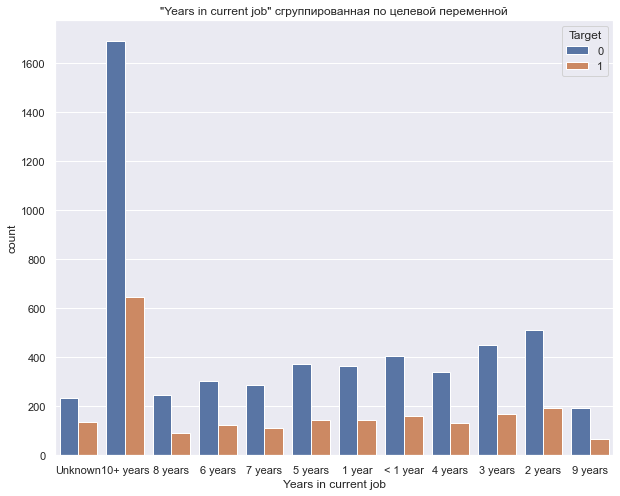

In [66]:
grouped_by_target(df_train, 'Years in current job', 'Credit Default')

In [67]:
df_train['Is_Years_in_current_job'] = df_train['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

In [68]:
df_test['Is_Years_in_current_job'] = df_test['Years in current job'].map({'Unknown': '-1',
                                                                            '< 1 year': '0',
                                                                            '1 year': '1',
                                                                            '2 years': '2',
                                                                            '3 years': '3',
                                                                            '4 years': '4',
                                                                            '5 years': '5',
                                                                            '6 years': '6',
                                                                            '7 years': '7',
                                                                            '8 years': '8',
                                                                            '9 years': '9',
                                                                            '10+ years': '10'}).astype(int)

##### Home Ownership

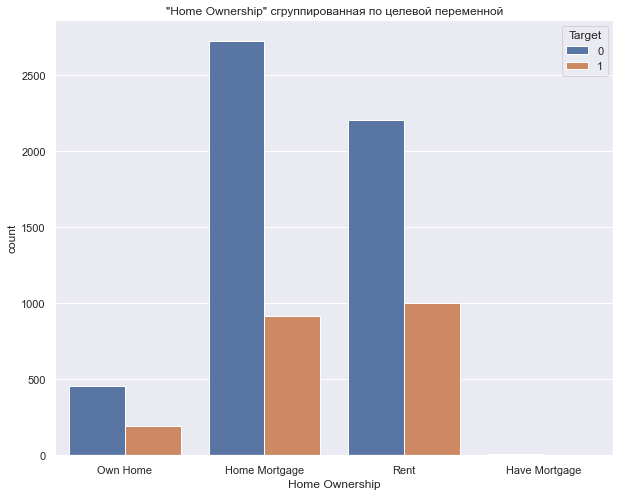

In [69]:
grouped_by_target(df_train, 'Home Ownership', 'Credit Default')

In [70]:
combine_into_category_table(df_train, 'Home Ownership', 'Credit Default', 'ID')

,Own Home,Home Mortgage,Rent,Have Mortgage
Own Home,,False,True,True
Home Mortgage,False,,False,True
Rent,True,False,,True
Have Mortgage,True,True,True,


Вывод: значения "Own Home", "Rent" и "Have Mortgage" можно собрать в одно значение

In [71]:
df_train['Is_Home_Ownership'] = df_train['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

df_test['Is_Home_Ownership'] = df_test['Home Ownership'].map({'Own Home':'0', 
                                                                'Rent':'0', 
                                                                'Have Mortgage':'0', 
                                                                'Home Mortgage':'1'}).astype(int)

##### Purpose

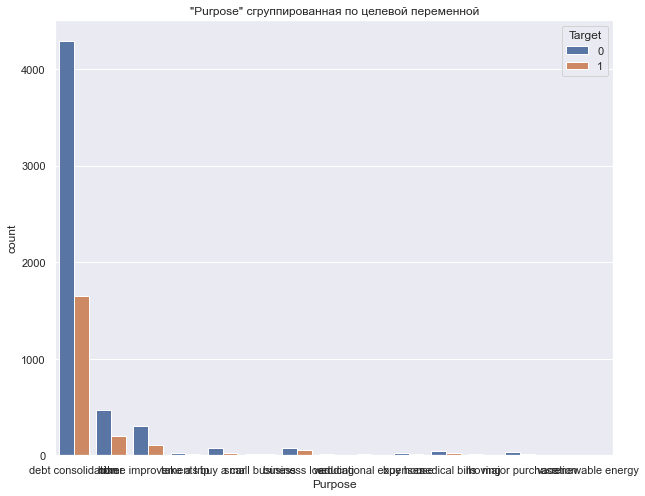

In [72]:
grouped_by_target(df_train, 'Purpose', 'Credit Default')

Чтобы не менять уже существующие параметры общей вспомогательной функции, оставим график как есть. Описание примерно понятно.

In [73]:
combine_into_category_table(df_train, 'Purpose', 'Credit Default', 'ID')

,debt consolidation,other,home improvements,take a trip,buy a car,small business,business loan,wedding,educational expenses,buy house,medical bills,moving,major purchase,vacation,renewable energy
debt consolidation,,True,True,True,True,False,False,True,True,True,True,True,True,True,False
other,True,,True,True,True,False,False,True,True,True,True,True,True,True,False
home improvements,True,True,,True,True,False,False,True,True,True,True,True,True,True,False
take a trip,True,True,True,,True,False,True,True,True,True,True,True,True,True,False
buy a car,True,True,True,True,,False,False,True,True,True,True,True,True,True,False
small business,False,False,False,False,False,,True,True,False,False,False,False,False,True,False
business loan,False,False,False,True,False,True,,True,False,True,True,True,False,True,False
wedding,True,True,True,True,True,True,True,,True,True,True,True,True,True,False
educational expenses,True,True,True,True,True,False,False,True,,True,True,True,True,True,False
buy house,True,True,True,True,True,False,True,True,True,,True,True,True,True,False


Вывод: все значения показателя, кроме "small business", "business loan" и "renewable energy" можно собрать в одно значение.

In [74]:
df_train['Is_Purpose'] = df_train['Purpose'].map({'debt consolidation':'other',
                                                  'other':'other',
                                                  'home improvements':'other',
                                                  'take a trip':'other',
                                                  'buy a car':'other',
                                                  'small business':'small business',
                                                  'business loan':'business loan',
                                                  'wedding':'other',
                                                  'educational expenses':'other',
                                                  'buy house':'other',
                                                  'medical bills':'other',
                                                  'moving':'other',
                                                  'major purchase':'other',
                                                  'vacation':'other',
                                                  'renewable energy':'renewable energy'})

df_test['Is_Purpose'] = df_test['Purpose'].map({'debt consolidation':'other',
                                                'other':'other',
                                                'home improvements':'other',
                                                'take a trip':'other',
                                                'buy a car':'other',
                                                'small business':'small business',
                                                'business loan':'business loan',
                                                'wedding':'other',
                                                'educational expenses':'other',
                                                'buy house':'other',
                                                'medical bills':'other',
                                                'moving':'other',
                                                'major purchase':'other',
                                                'vacation':'other',
                                                'renewable energy':'renewable energy'})

In [75]:
df_train = pd.concat([df_train, pd.get_dummies(df_train['Is_Purpose'], prefix='Is_Purpose')], axis=1)
df_test = pd.concat([df_test, pd.get_dummies(df_test['Is_Purpose'], prefix='Is_Purpose')], axis=1)

### Анализ данных

#### Выделение целевой переменной и групп признаков

In [76]:
TARGET_NAME = 'Credit Default'
BASE_FEATURE_NAMES = df_base.columns.drop(TARGET_NAME).tolist()
NEW_FEATURE_NAMES = df_train.columns.drop([TARGET_NAME] + BASE_FEATURE_NAMES)

In [77]:
BASE_FEATURE_NAMES

['Home Ownership',
 'Annual Income',
 'Years in current job',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Bankruptcies',
 'Purpose',
 'Term',
 'Current Loan Amount',
 'Current Credit Balance',
 'Monthly Debt',
 'Credit Score']

In [78]:
NEW_FEATURE_NAMES

Index(['ID', 'Is_Term', 'Is_Years_in_current_job', 'Is_Home_Ownership',
       'Is_Purpose', 'Is_Purpose_business loan', 'Is_Purpose_other',
       'Is_Purpose_renewable energy', 'Is_Purpose_small business'],
      dtype='object')

#### Анализ целевой переменной

In [79]:
df_train[TARGET_NAME].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

Вывод: существует некоторая диспропорция

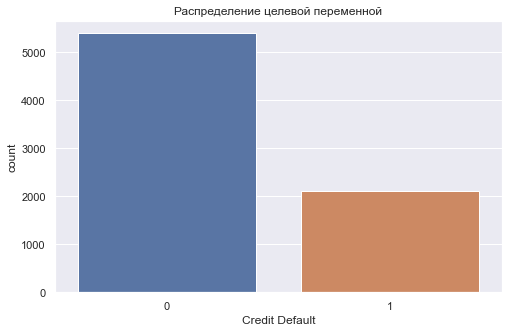

In [80]:
plt.figure(figsize=(8, 5))
sns.countplot(x=TARGET_NAME, data=df_train)
plt.title('Распределение целевой переменной')
plt.show()

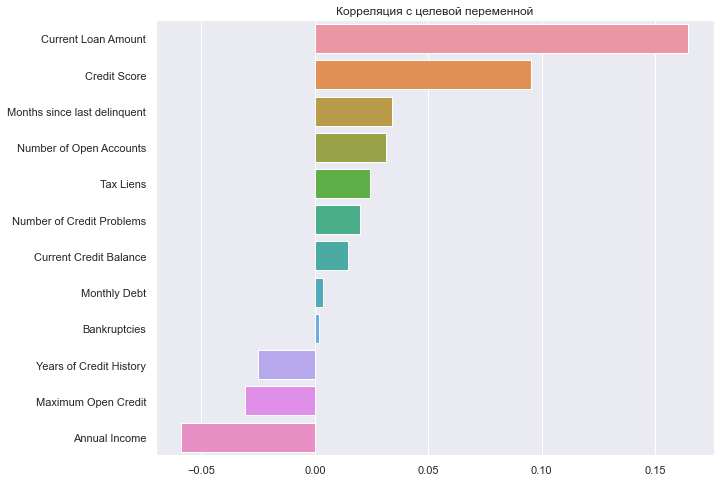

In [81]:
corr_with_target = df_train[BASE_FEATURE_NAMES + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(x=corr_with_target.values, y=corr_with_target.index)
plt.title('Корреляция с целевой переменной')
plt.show()

Поскольку у таких показателей, как: 

* Tax Liens
* Number of Credit Problems
* Bankruptcies

мало классов, то, возможно, имеет смысл сделать их категориальными

__Оценка признака «Annual Income» в разрезе целевой переменной__

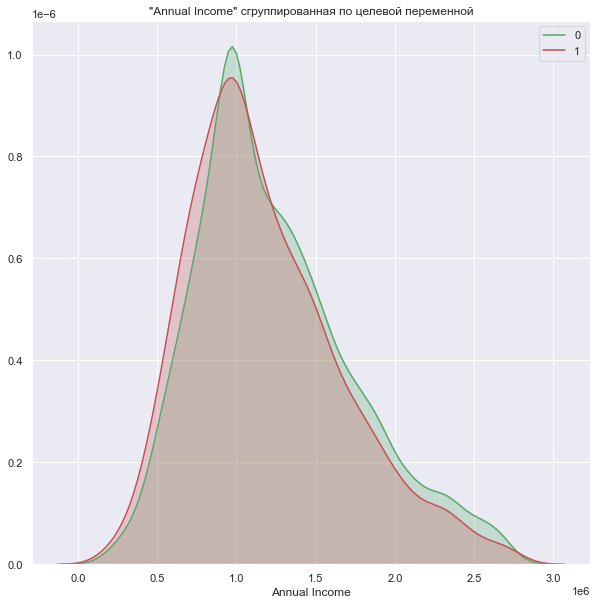

Показатель «Annual Income» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


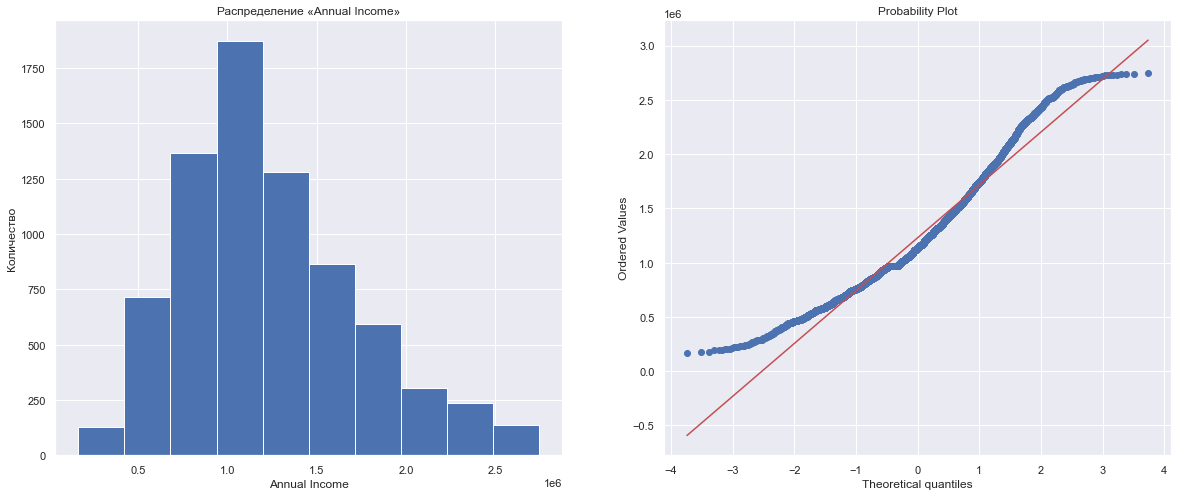

По показателю «Annual Income» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


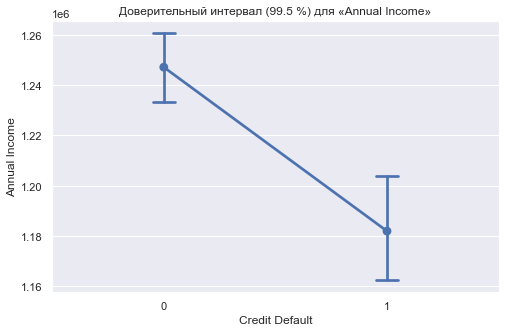

__Оценка признака «Tax Liens» в разрезе целевой переменной__

Показатель «Tax Liens» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


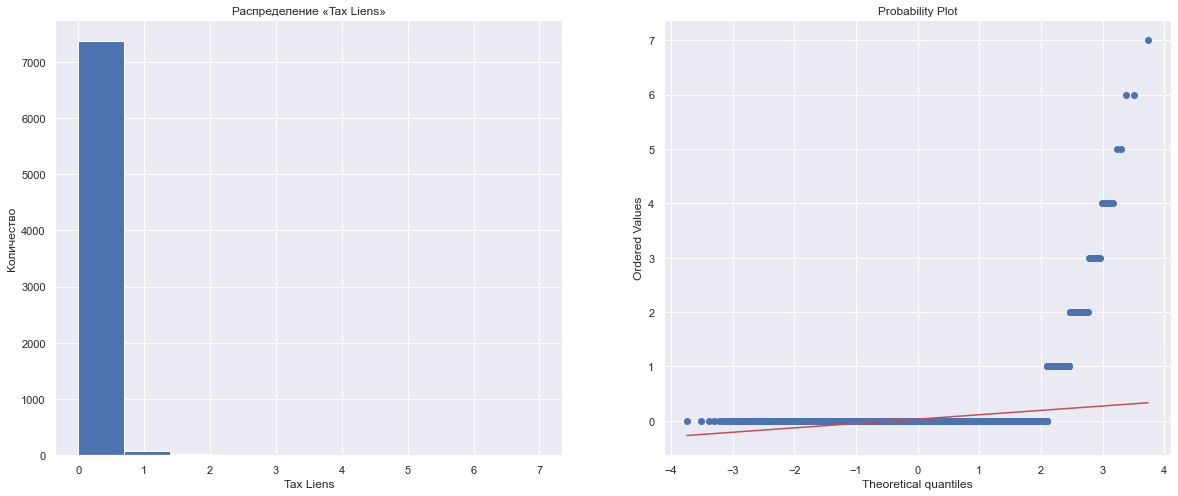

По показателю «Tax Liens» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


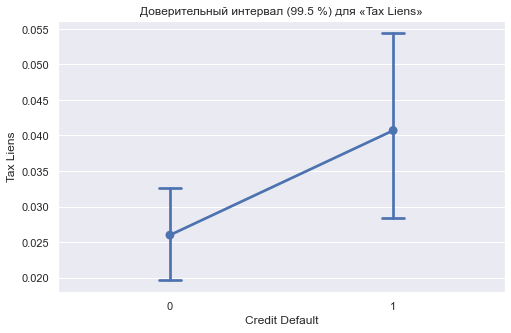

__Оценка признака «Number of Open Accounts» в разрезе целевой переменной__

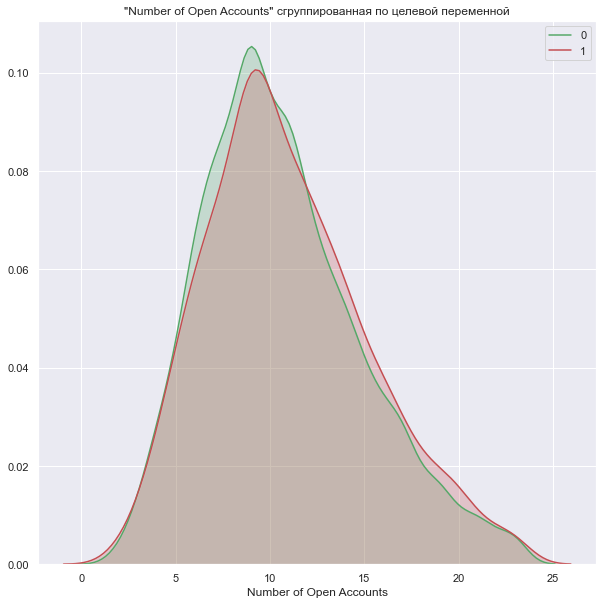

Показатель «Number of Open Accounts» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


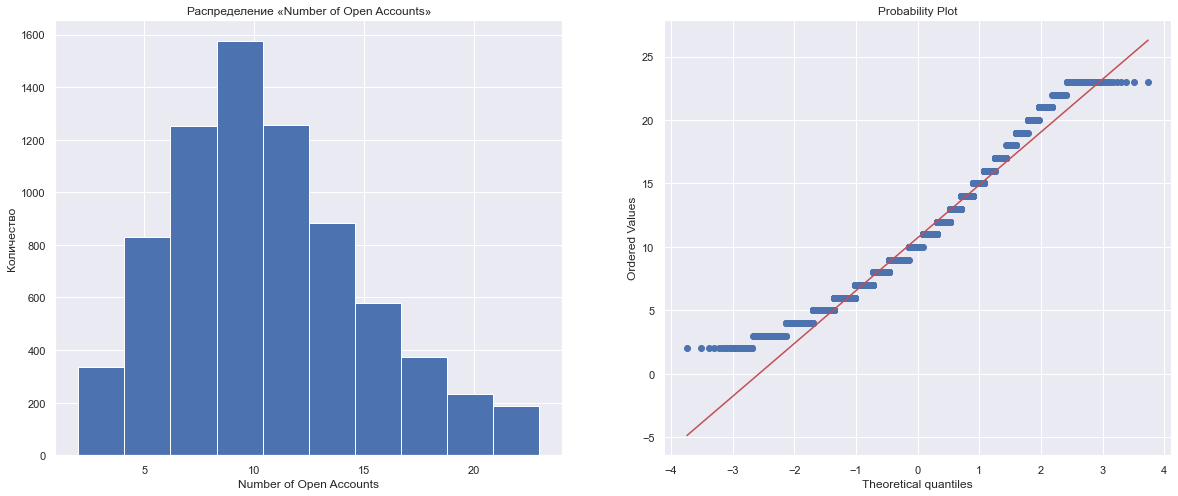

По показателю «Number of Open Accounts» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


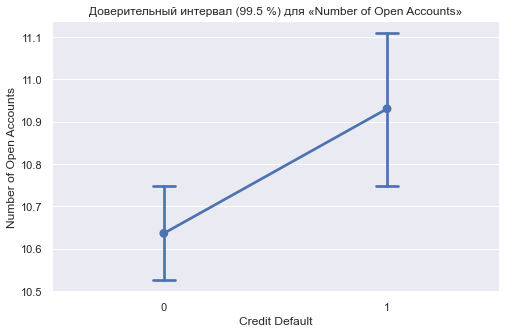

__Оценка признака «Years of Credit History» в разрезе целевой переменной__

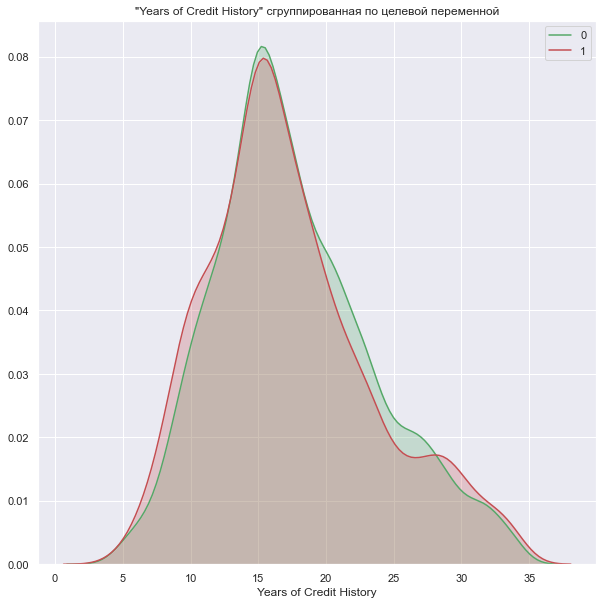

Показатель «Years of Credit History» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


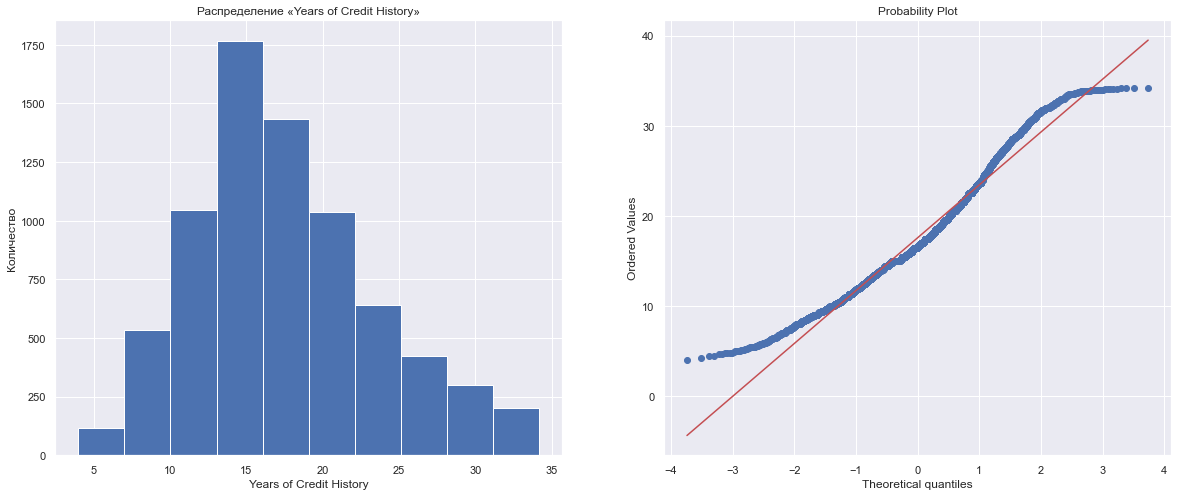

По показателю «Years of Credit History» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


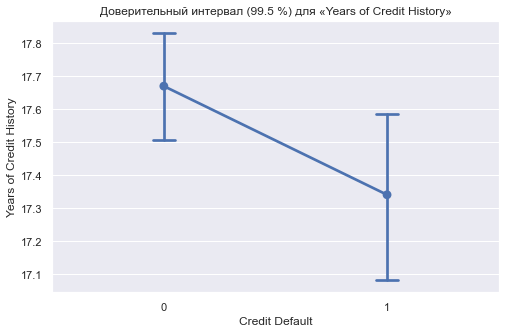

__Оценка признака «Maximum Open Credit» в разрезе целевой переменной__

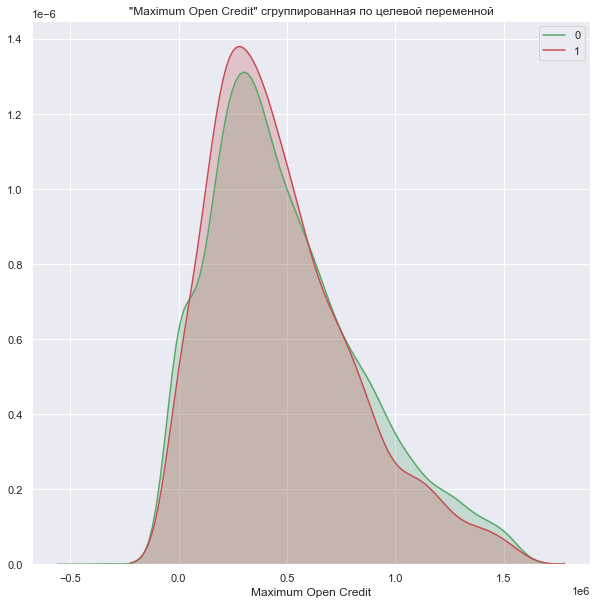

Показатель «Maximum Open Credit» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


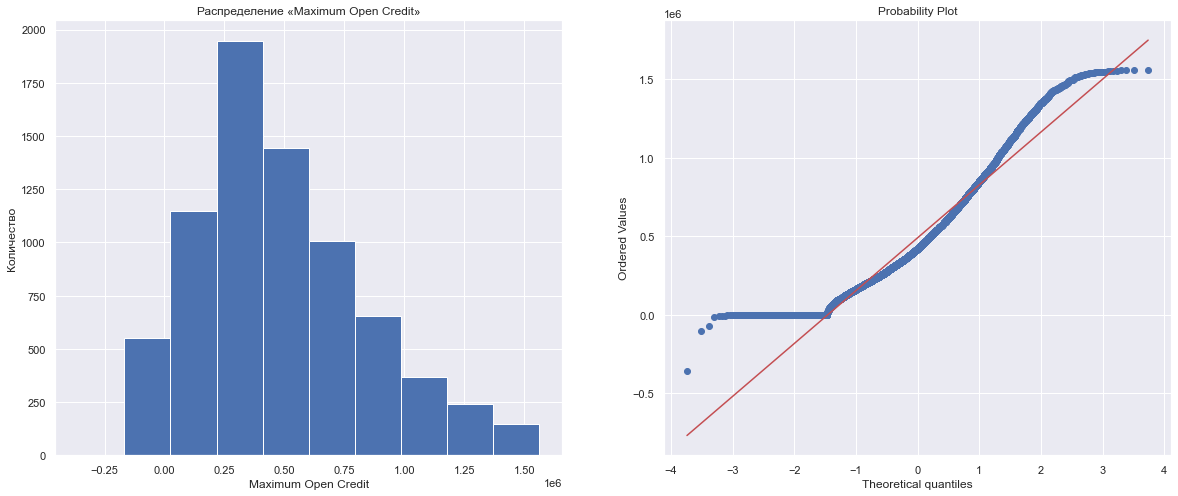

По показателю «Maximum Open Credit» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


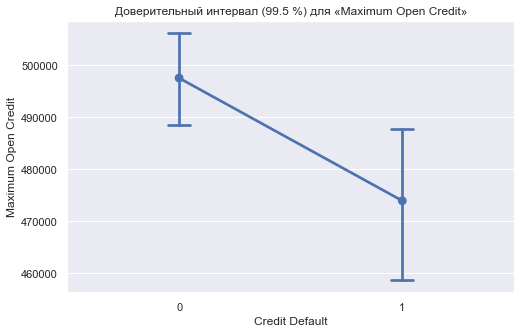

__Оценка признака «Number of Credit Problems» в разрезе целевой переменной__

Показатель «Number of Credit Problems» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


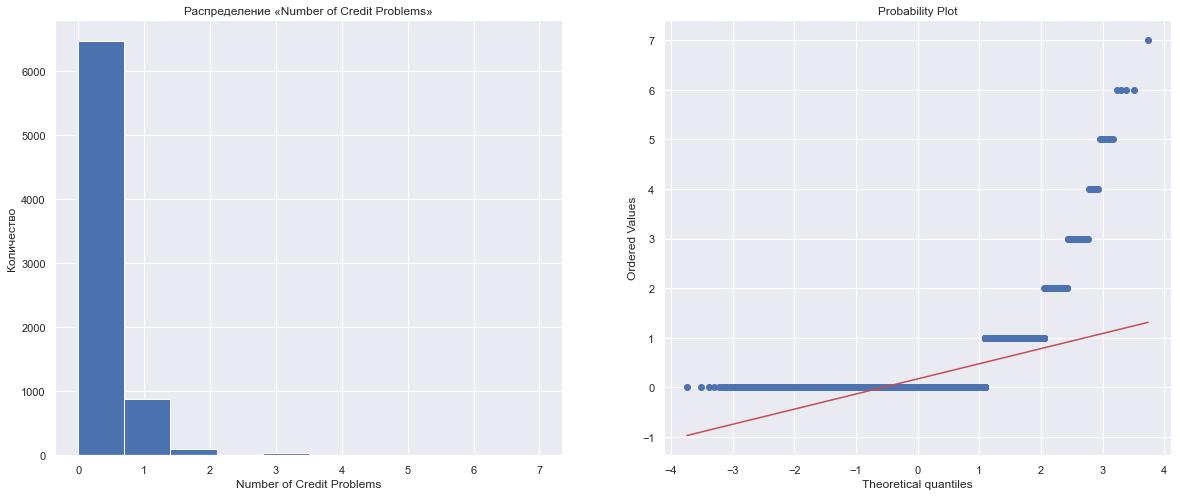

По показателю «Number of Credit Problems» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


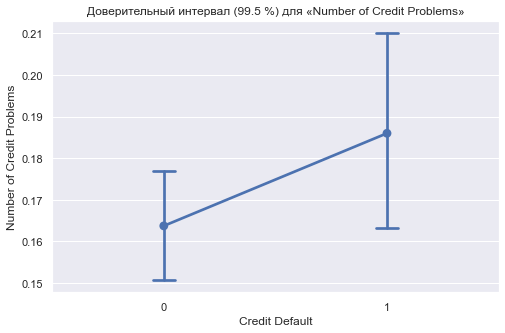

__Оценка признака «Months since last delinquent» в разрезе целевой переменной__

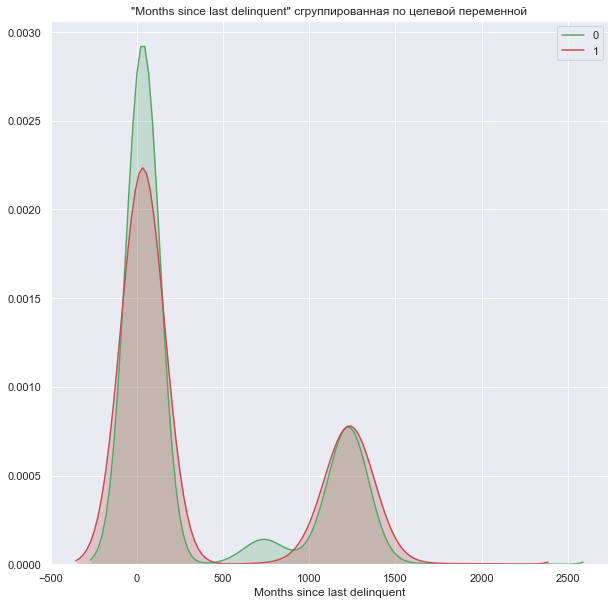

Показатель «Months since last delinquent» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


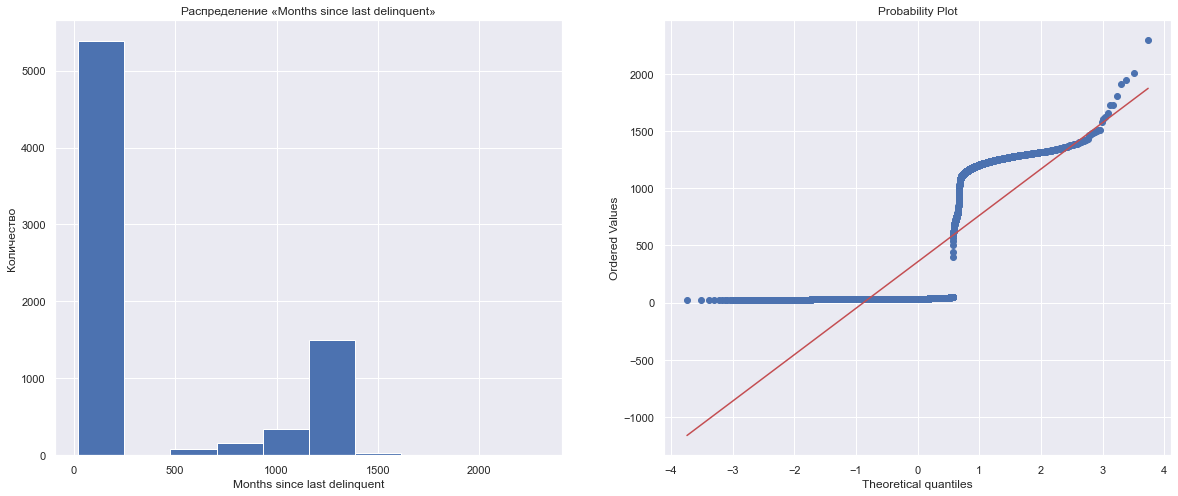

По показателю «Months since last delinquent» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


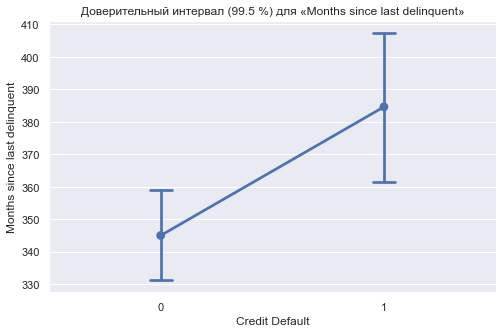

__Оценка признака «Bankruptcies» в разрезе целевой переменной__

Показатель «Bankruptcies» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


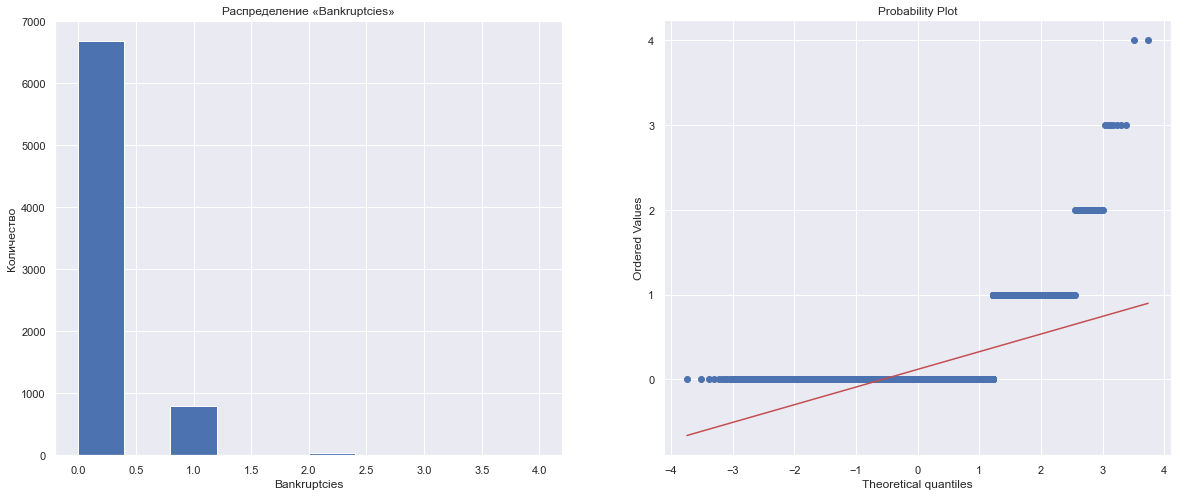

По показателю «Bankruptcies» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


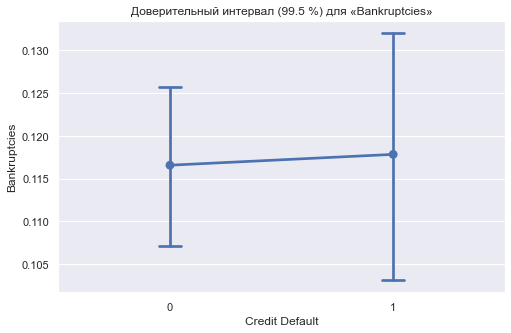

__Оценка признака «Current Loan Amount» в разрезе целевой переменной__

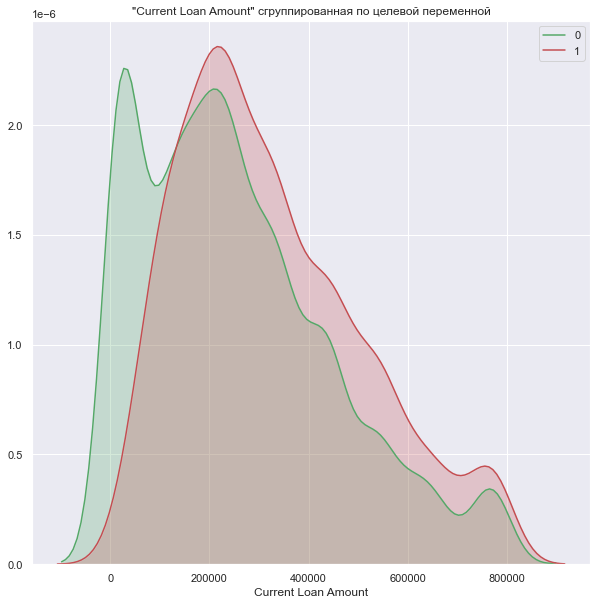

Показатель «Current Loan Amount» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


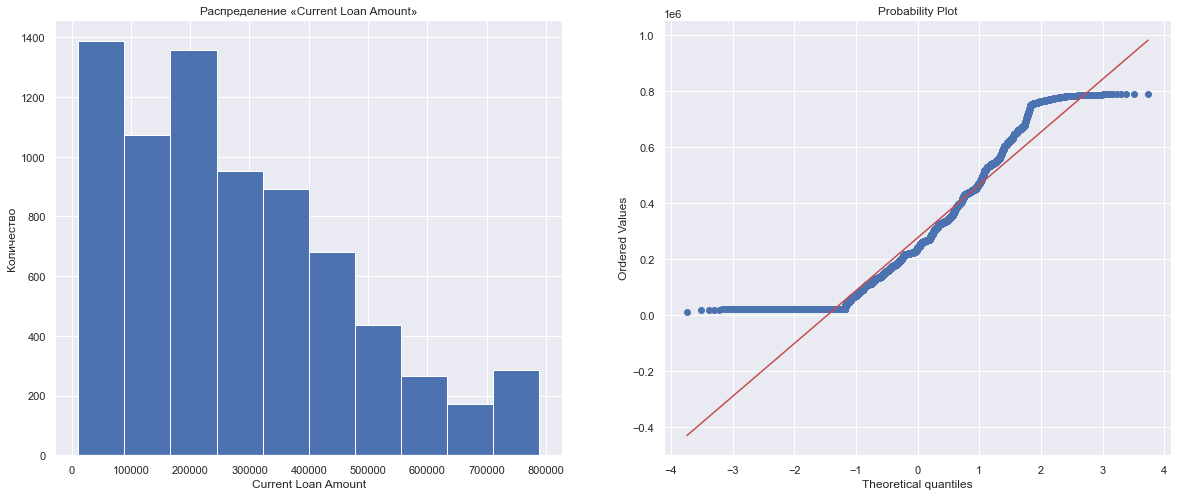

По показателю «Current Loan Amount» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


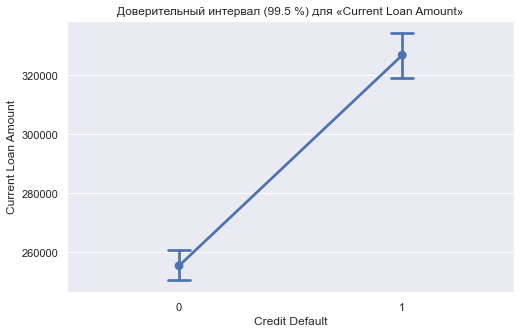

__Оценка признака «Current Credit Balance» в разрезе целевой переменной__

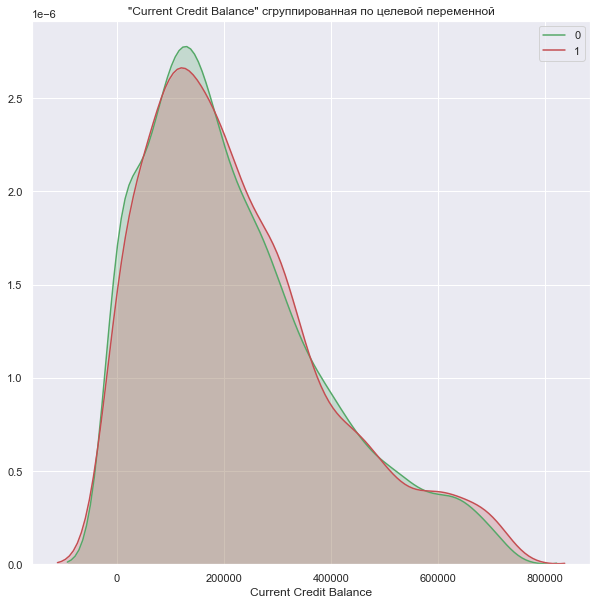

Показатель «Current Credit Balance» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


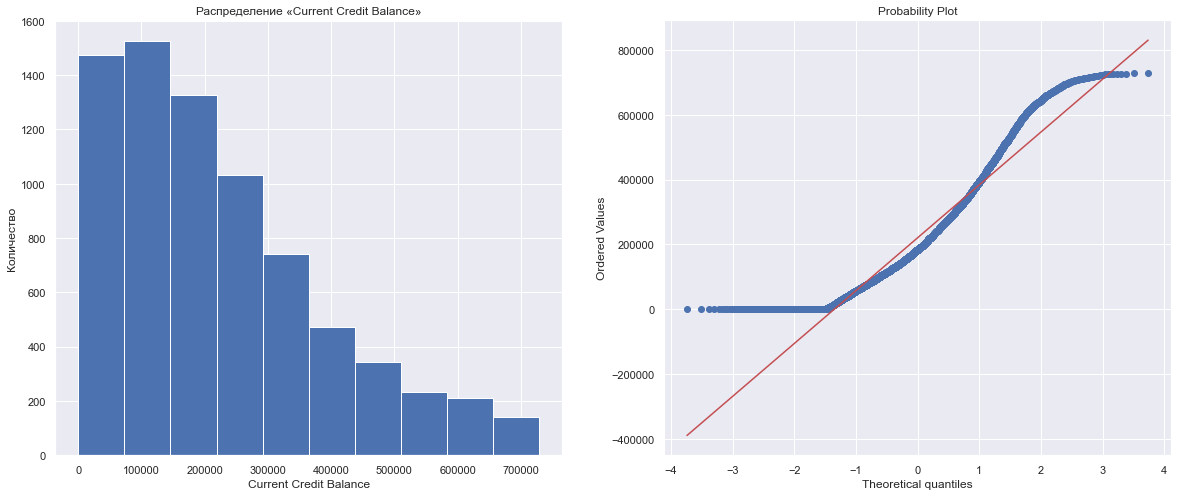

По показателю «Current Credit Balance» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


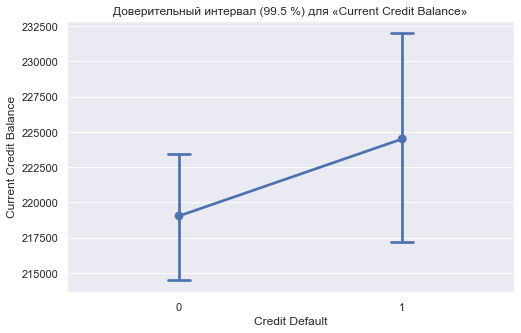

__Оценка признака «Monthly Debt» в разрезе целевой переменной__

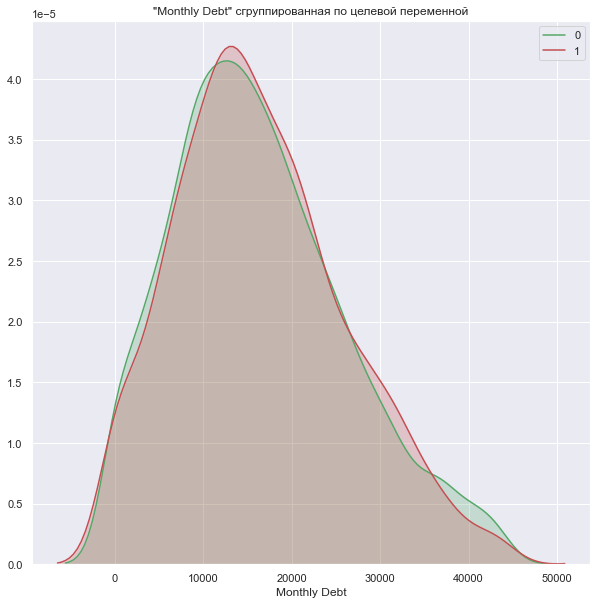

Показатель «Monthly Debt» показатель нормализуется операцией логарифмирования.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


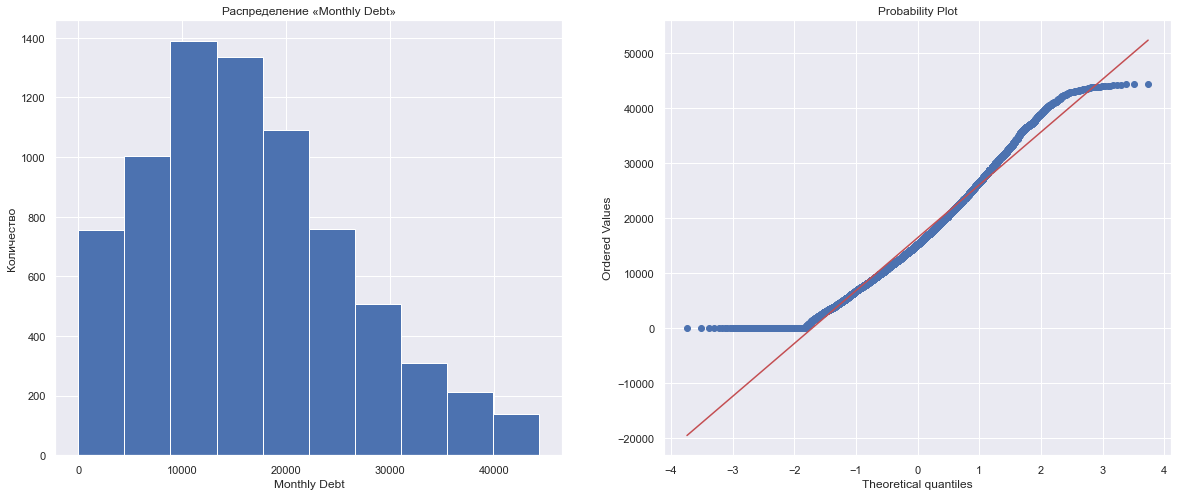

По показателю «Monthly Debt» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


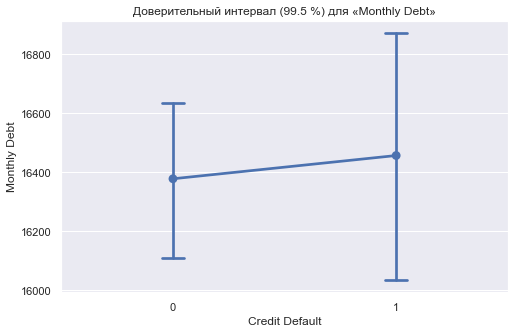

__Оценка признака «Credit Score» в разрезе целевой переменной__

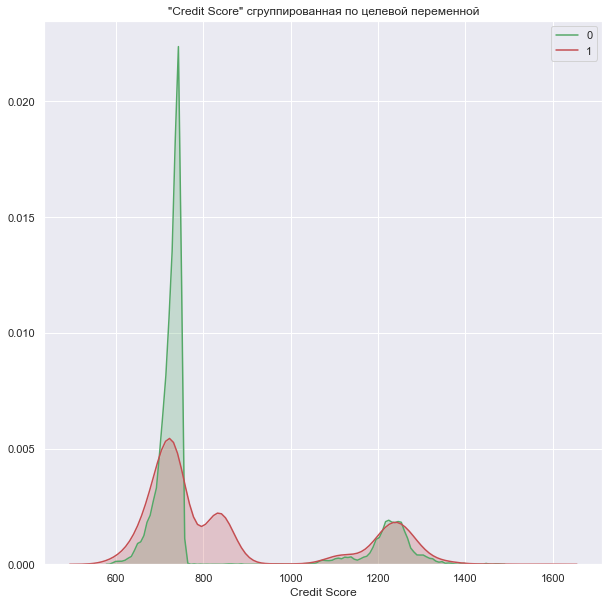

Показатель «Credit Score» не соответствует нормальному распределнию.
Для достоверности произведём визуальную оценку распределения признака, а так же построим QQ-график.


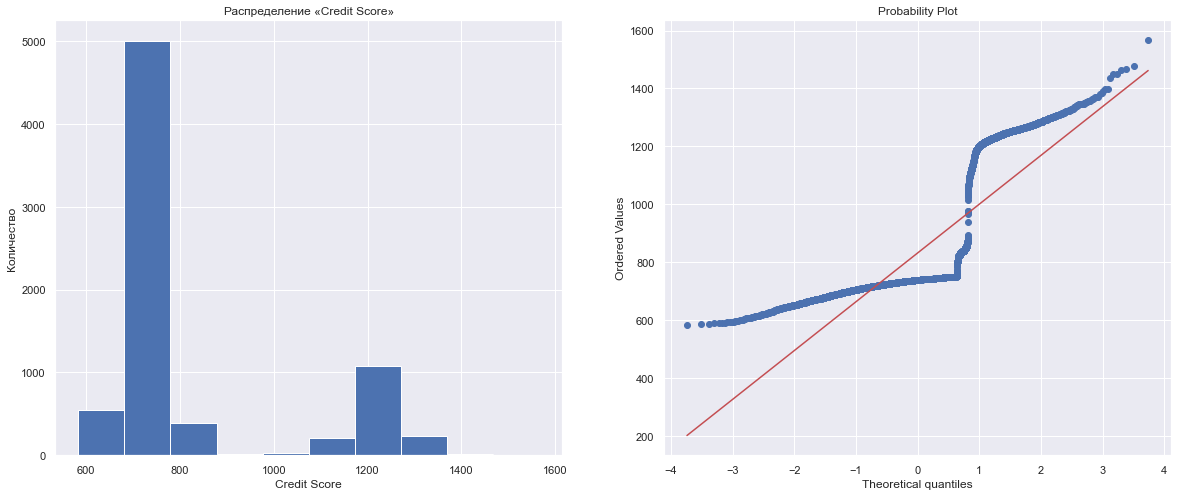

По показателю «Credit Score» можно построить модель.
Для достоверности произведём визуальную оценку доверительного интервала.


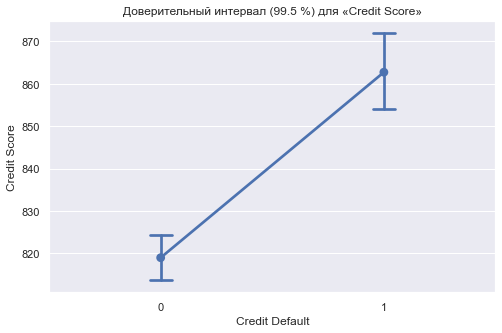

In [82]:
for cat_colname in df_train[BASE_FEATURE_NAMES].select_dtypes(include=['float64'], exclude=['object']).columns:
        if 'Tax Liens' == cat_colname or 'Number of Credit Problems' == cat_colname or 'Bankruptcies' == cat_colname:
            check_rate(df_train, TARGET_NAME, cat_colname, False)
        else:
            check_rate(df_train, TARGET_NAME, cat_colname)

Итоги анализа:

показатели, которые не влияют на целевую переменную, и поэтому можно от нихизбавиться:

* Bankruptcies
* Monthly Debt

Показатели, которые необходимо нормализовать логарифмированием:

* Maximum Open Credit
* Current Credit Balance

Показатели, которые имеют несущественное влияние на целевую переменную:

* Tax Liens
* Years of Credit History
* Number of Credit Problems
* Current Credit Balance

И, наконец, показатели, которые существенно влияют на целевую переменную:

* Annual Income
* Number of Open Accounts
* Maximum Open Credit
* Months since last delinquent
* Current Loan Amount
* Credit Score

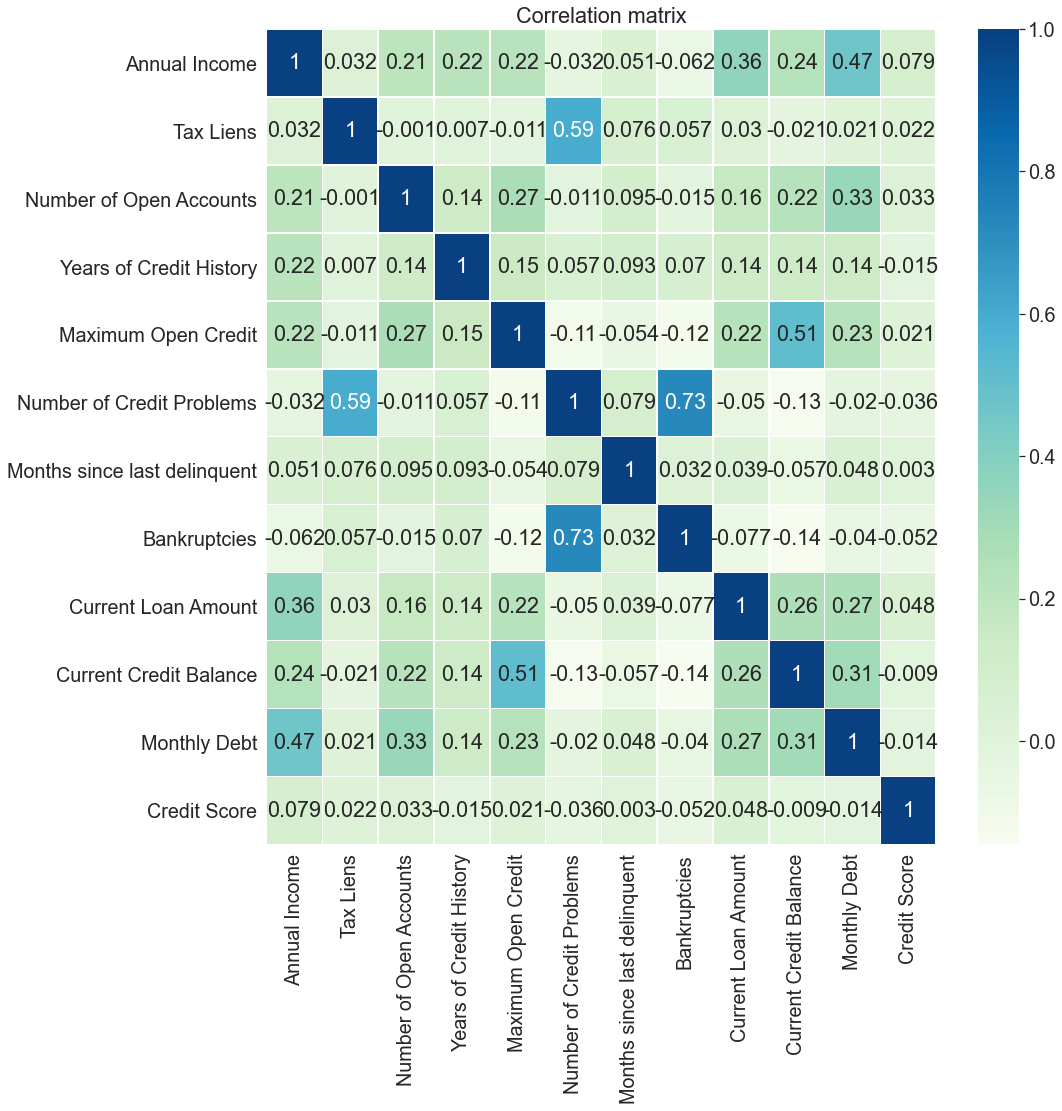

In [83]:
plt.figure(figsize = (15, 15))

sns.set(font_scale=1.8)
sns.heatmap(df_train[BASE_FEATURE_NAMES].corr().round(3), annot=True, linewidths=.5, cmap='GnBu')

plt.title('Correlation matrix')
plt.show()

### Отбор признаков

In [84]:
NUM_FEATURE_NAMES = ['Annual Income',
                     'Tax Liens',
                     'Number of Open Accounts',
                     'Years of Credit History',
                     'Maximum Open Credit',
                     'Number of Credit Problems',
                     'Months since last delinquent',
                     'Current Loan Amount',
                     'Current Credit Balance',
                     'Credit Score',
                     'Is_Years_in_current_job']

In [85]:
CAT_FEATURE_NAMES = ['Is_Term',
                     'Is_Home_Ownership',
                     'Is_Purpose_business loan',
                     'Is_Purpose_other',
                     'Is_Purpose_small business']

In [86]:
SELECTED_FEATURE_NAMES = NUM_FEATURE_NAMES + CAT_FEATURE_NAMES

In [87]:
SELECTED_FEATURE_NAMES

['Annual Income',
 'Tax Liens',
 'Number of Open Accounts',
 'Years of Credit History',
 'Maximum Open Credit',
 'Number of Credit Problems',
 'Months since last delinquent',
 'Current Loan Amount',
 'Current Credit Balance',
 'Credit Score',
 'Is_Years_in_current_job',
 'Is_Term',
 'Is_Home_Ownership',
 'Is_Purpose_business loan',
 'Is_Purpose_other',
 'Is_Purpose_small business']

#### Нормализация данных

In [88]:
scaler = StandardScaler()

df_norm = df_train.copy()
df_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_norm[NUM_FEATURE_NAMES])

df_train = df_norm.copy()

In [89]:
df_test_norm = df_test.copy()
df_test_norm[NUM_FEATURE_NAMES] = scaler.fit_transform(df_test_norm[NUM_FEATURE_NAMES])

df_test = df_test_norm.copy()

#### Сохранение модели для нормализации данных

In [90]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

#### Разбиение на train и test

In [91]:
X = df_train[SELECTED_FEATURE_NAMES]
y = df_train[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=42)

### Балансировка целевой переменной

In [92]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, TARGET_NAME)
    
df_balanced[TARGET_NAME].value_counts()

0    3795
1    2910
Name: Credit Default, dtype: int64

In [93]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

#### Сохранение обучающего и тестового датасетов

In [94]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [95]:
df_train.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Подбор моделей

**knn**

In [96]:
model_knn = KNeighborsClassifier()
model_knn.fit(X_train, y_train)

y_train_pred = model_knn.predict(X_train)
y_test_pred = model_knn.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.77      0.85      0.81      3795
           1       0.77      0.67      0.72      2910

    accuracy                           0.77      6705
   macro avg       0.77      0.76      0.76      6705
weighted avg       0.77      0.77      0.77      6705

TEST

              precision    recall  f1-score   support

           0       0.74      0.73      0.74      1592
           1       0.36      0.36      0.36       658

    accuracy                           0.63      2250
   macro avg       0.55      0.55      0.55      2250
weighted avg       0.63      0.63      0.63      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1170  422
1                418  240


**Логистическая регрессия**

In [97]:
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)

y_train_pred = model_lr.predict(X_train)
y_test_pred = model_lr.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.65      0.77      0.71      3795
           1       0.61      0.46      0.53      2910

    accuracy                           0.64      6705
   macro avg       0.63      0.62      0.62      6705
weighted avg       0.63      0.64      0.63      6705

TEST

              precision    recall  f1-score   support

           0       0.77      0.77      0.77      1592
           1       0.43      0.43      0.43       658

    accuracy                           0.67      2250
   macro avg       0.60      0.60      0.60      2250
weighted avg       0.67      0.67      0.67      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1218  374
1                372  286


**XGBoost**

In [98]:
model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      3795
           1       0.98      0.97      0.98      2910

    accuracy                           0.98      6705
   macro avg       0.98      0.98      0.98      6705
weighted avg       0.98      0.98      0.98      6705

TEST

              precision    recall  f1-score   support

           0       0.79      0.85      0.82      1592
           1       0.55      0.45      0.49       658

    accuracy                           0.73      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1355  237
1                365  293


**LightGBM**

In [99]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.92      0.96      0.94      3795
           1       0.95      0.89      0.92      2910

    accuracy                           0.93      6705
   macro avg       0.93      0.93      0.93      6705
weighted avg       0.93      0.93      0.93      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1592
           1       0.56      0.48      0.52       658

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1344  248
1                342  316


**CatBoost**

In [100]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.96      0.92      3795
           1       0.95      0.83      0.88      2910

    accuracy                           0.90      6705
   macro avg       0.91      0.90      0.90      6705
weighted avg       0.91      0.90      0.90      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1592
           1       0.57      0.47      0.52       658

    accuracy                           0.74      2250
   macro avg       0.68      0.66      0.67      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1359  233
1                349  309


### Выбор наилучшей модели, настройка гиперпараметров

In [101]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=42)

In [102]:
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500], 'max_depth':[3, 5, 7]}

In [103]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [104]:
rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001FE5C76B460>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [105]:
rs.best_params_

{'n_estimators': 1000, 'max_depth': 3}

In [106]:
rs.best_score_

0.5386080887755159

#### Обучение и оценка финальной модели

In [107]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, silent=True, random_state=42)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.76      0.88      0.81      3795
           1       0.80      0.63      0.71      2910

    accuracy                           0.77      6705
   macro avg       0.78      0.76      0.76      6705
weighted avg       0.78      0.77      0.77      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.82      1592
           1       0.55      0.51      0.53       658

    accuracy                           0.73      2250
   macro avg       0.68      0.67      0.67      2250
weighted avg       0.73      0.73      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1319  273
1                324  334


In [108]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,silent=True, random_state=42)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)
y_test_pred_probs = final_model.predict_proba(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      3795
           1       0.84      0.69      0.76      2910

    accuracy                           0.81      6705
   macro avg       0.81      0.79      0.80      6705
weighted avg       0.81      0.81      0.80      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1592
           1       0.54      0.49      0.51       658

    accuracy                           0.73      2250
   macro avg       0.67      0.66      0.66      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1318  274
1                337  321


#### Подбор оптимального размера выборки, кривая обучения

In [109]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3,
                                      class_weights=[1, 3.5],
                                      silent=True, random_state=42)
final_model.fit(X_train, y_train)

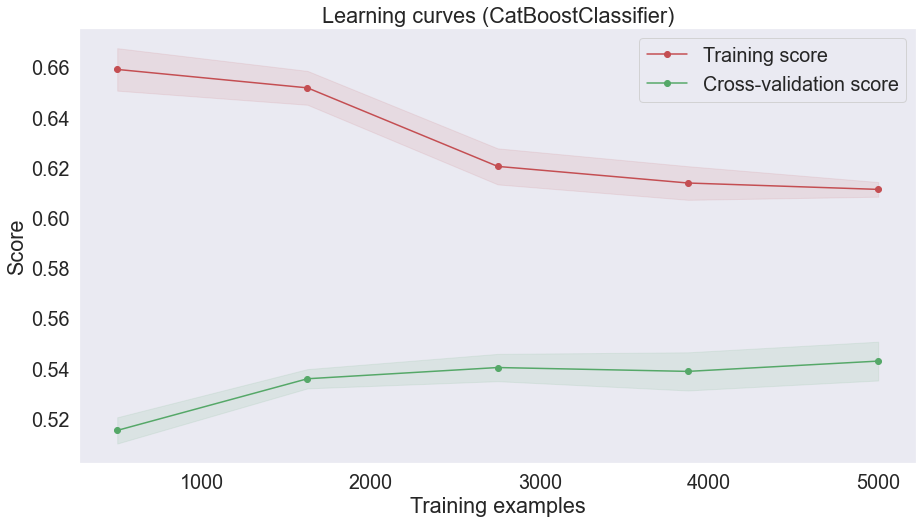

In [110]:
show_learning_curve_plot(final_model, X, y)

#### Выбор порога вероятности для определения класса

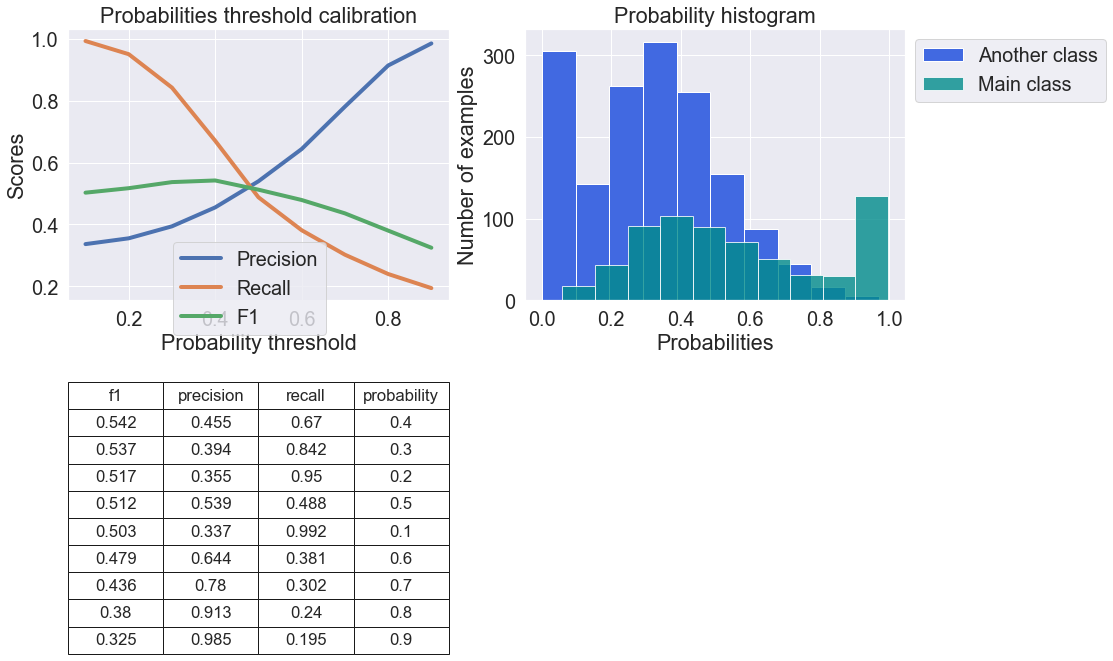

In [111]:
show_proba_calibration_plots(y_test_pred_probs[:, 1], y_test)

#### Важность признаков

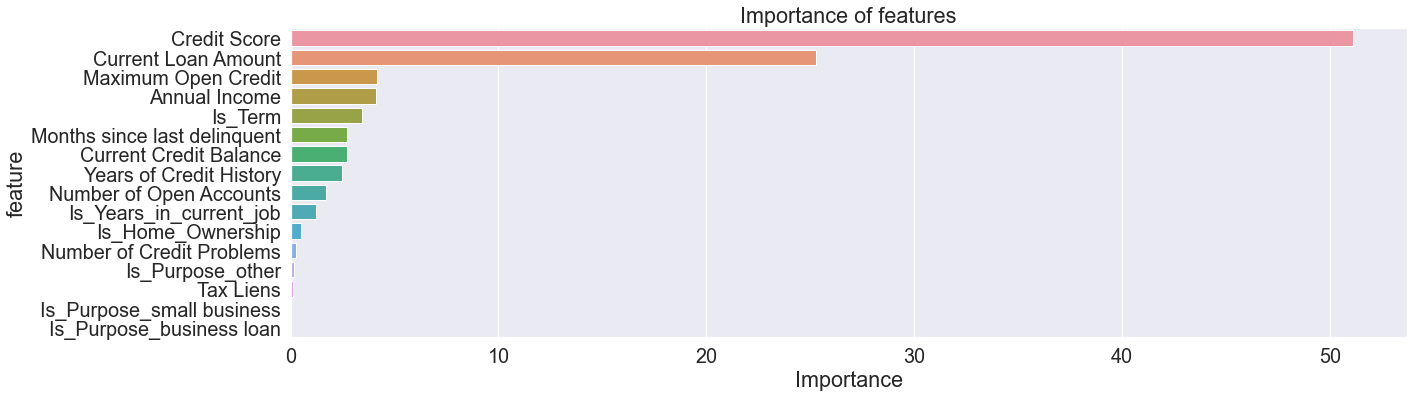

In [112]:
important_features_top = show_feature_importances(X_train.columns, final_model.feature_importances_, get_top=10)

### Финальная модель

In [113]:
final_model = catb.CatBoostClassifier(n_estimators=1500, max_depth=3, l2_leaf_reg=10,
                                      silent=True, random_state=42)
final_model.fit(X_train[important_features_top], y_train)

y_train_pred = final_model.predict(X_train[important_features_top])
y_test_pred = final_model.predict(X_test[important_features_top])
y_test_pred_probs = final_model.predict_proba(X_test[important_features_top])

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.79      0.90      0.84      3795
           1       0.83      0.69      0.75      2910

    accuracy                           0.80      6705
   macro avg       0.81      0.79      0.80      6705
weighted avg       0.81      0.80      0.80      6705

TEST

              precision    recall  f1-score   support

           0       0.80      0.82      0.81      1592
           1       0.53      0.50      0.52       658

    accuracy                           0.72      2250
   macro avg       0.66      0.66      0.66      2250
weighted avg       0.72      0.72      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1302  290
1                329  329


**Сохранение модели**

In [114]:
with open(MODEL_FILE_PATH, 'wb') as file:
    pickle.dump(final_model, file)

### Интерпритация результатов

In [115]:
y_result = final_model.predict(df_test[important_features_top])

In [116]:
result = pd.DataFrame({'ID': df_test['ID'], 'Credit Default': y_result})

In [117]:
result['Credit Default'].value_counts()

0    1790
1     710
Name: Credit Default, dtype: int64

In [118]:
result.to_csv(RESULT_FILE_PATH, index=False, encoding='utf-8')